# Time Series Forecasting with LSTMs

In this example we will work on the 

### Shampoo Sales Dataset

- This dataset describes the monthly number of sales of shampoo over a 3-year period.

- The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

### Kaggle Download link for dataset 
https://www.kaggle.com/datasets/redwankarimsony/shampoo-saled-dataset



#### REFERENCES


https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

https://theaisummer.com/understanding-lstm/

https://sullah.medium.com/understanding-lstms-from-scratch-pytorch-7020211fed40

https://wandb.ai/authors/rnn-viz/reports/Under-the-Hood-of-Long-Short-Term-Memory-LSTM---VmlldzoyNjY0MTg?galleryTag=intermediate





#### Imports 

In [1]:
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

#### Load Time Series Data 

In [2]:
import pandas as pd
from datetime import datetime

# Define Time Series Data parser
def parser(x):
    return datetime.strptime('19' + x, '%Y-%b')

# Read Series
df = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)

# Convert to Series if it has a single column
if df.shape[1] == 1:
    series = df.squeeze(axis=1)
else:
    series = df

# Check
print(series.head())


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


/var/folders/1m/07kgjdg97477jnhwzd0w8gyh0000gn/T/ipykernel_20871/2617134058.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)


#### Plot Series 

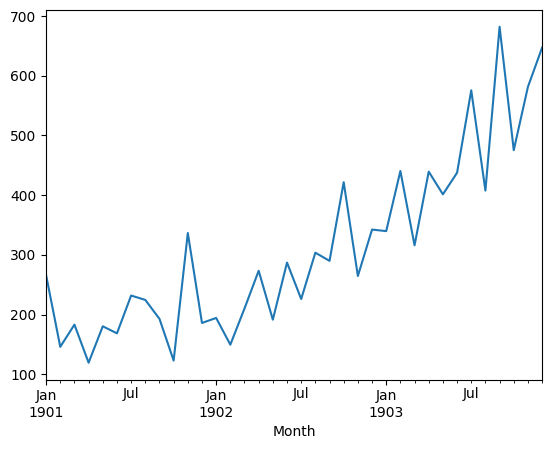

In [3]:
series.plot()
pyplot.show()

###  Train Test Split 

- We will split the Shampoo Sales dataset into two parts: a training and a test set.

- The first two years of data will be taken for the training dataset and the remaining one year of data will be used for the test set.

In [4]:
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

## Baseline - Persistence Model Forecast

- A good baseline forecast for a time series with a linear increasing trend is a persistence forecast.

- The persistence forecast is where the observation from the prior time step (t-1) is used to predict the observation at the current time step (t).

- We can implement this by taking the last observation from the training data and history accumulated by walk-forward validation and using that to predict the current time step.


In [5]:
# walk-forward validation
history = [x for x in train]

# define empty list for predictions 
predictions = list()

# the current prediction is the last history value 
# 1 History is set to all the train data points 
# 2 We loop iteratively to extract the last history value and treat it as current time prediction
# 3 We then add to history one future observation from test. 
# 4 The steps 2-3 are repeated 


for i in range(len(test)):
 # make prediction
 predictions.append(history[-1])
 # observation
 history.append(test[i])
    



#### Check performance 

In [6]:
    
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)



RMSE: 136.761


#### Plots 

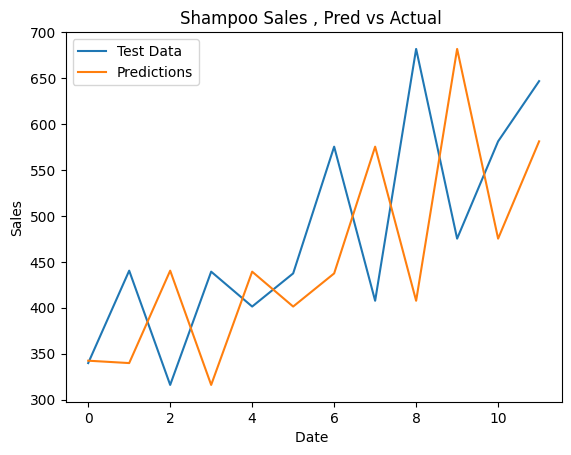

In [7]:
import matplotlib.pyplot as pyplot


pyplot.plot(test, label='Test Data')
pyplot.plot(predictions, label='Predictions')

# Adding labels
pyplot.xlabel('Date ')  
pyplot.ylabel('Sales')  

# Adding title
pyplot.title('Shampoo Sales , Pred vs Actual ')  

# Adding legend
pyplot.legend()

# Display the plot
pyplot.show()


## LSTM Data Preparation  

The Data preparation involves the below key steps 

- Transform the time series into a supervised learning problem
- Transform the time series data so that it is stationary.
- Transform the observations to have a specific scale.

### Transform Time Series to Supervised Learning

- For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

- We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. 

- We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.


#### The Above is achieved with the function "add_shifted_column

In [8]:
import pandas as pd

def add_shifted_column(series: pd.Series) -> pd.DataFrame:
    """
    Adds a new column to a DataFrame created from a pandas Series. 
    The new column will have the series values shifted down by one position, 
    and any resulting NaN values will be filled with zeros.

    Parameters:
    series (pd.Series): The input pandas Series containing univariate time series data.

    Returns:
    pd.DataFrame: A DataFrame with two columns:
                 - The original series
                 - The shifted series (shifted down by one position, with NaNs filled with zeros)
    """
    # Convert the series to a DataFrame
    df = series.to_frame(name='Original')

    # Shift the series down by one position and add as a new column
    df['Shifted'] = df['Original'].shift(1)

    # Fill any NaN values with zeros
    df.fillna(0, inplace=True)

    return df

In [9]:
# Test add_shifted_column
supervised_df = add_shifted_column(series)

# check
supervised_df.head()

,Original,Shifted
Month,,
1901-01-01,266.0,0.0
1901-02-01,145.9,266.0
1901-03-01,183.1,145.9
1901-04-01,119.3,183.1
1901-05-01,180.3,119.3


###  Transforming Time Series Data to Stationary 

- The Shampoo Sales dataset is not stationary.

- This means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.


- The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

- A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

- We can achieve this automatically using the diff() function in pandas. Alternatively, we can get finer grained control and write our own function to do this, which is preferred for its flexibility in this case.


#### The  function difference_series achieves the same 

In [10]:
import pandas as pd

def difference_series(series: pd.Series, interval: int = 1) -> pd.Series:
    """
    Computes the differenced series by subtracting each value from the value `interval` positions before it.
    
    Parameters:
    series (pd.Series): The input pandas Series to be differenced.
    interval (int): The number of periods to shift for calculating the difference. Default is 1.
    
    Returns:
    pd.Series: A pandas Series containing the differenced values.
    """
    # Calculate the difference based on the interval    
    diff = list()
    for i in range(interval, len(series)):
            value = series[i] - series[i - interval]
            diff.append(value)
    return pd.Series(diff)

### Plot and check 

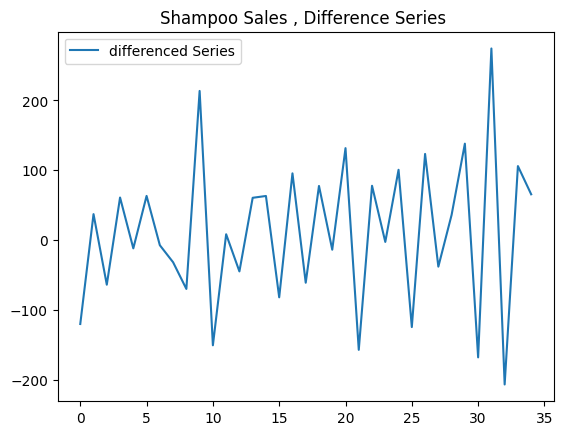

In [11]:
# check 
diff_series = difference_series(series)

# plot orginal vs difference
import matplotlib.pyplot as pyplot


pyplot.plot(diff_series, label='differenced Series')
#pyplot.plot(diff_series, label='differenced Series')

 

# Adding title
pyplot.title('Shampoo Sales , Difference Series ')  

# Adding legend
pyplot.legend()

# Display the plot
pyplot.show()

 #### Inverting the differenced series 
 
- We also need to invert this process in order to take forecasts made on the differenced series back into their original scale.

- The function below, called inverse_difference(), inverts this operation.

In [12]:
import pandas as pd

def inverse_difference(original_series: pd.Series, differenced_series: pd.Series) -> pd.Series:
    """
    Inverts a differenced series to recover the original series values.
    
    Parameters:
    original_series (pd.Series): The original pandas Series before differencing.
    differenced_series (pd.Series): The differenced pandas Series to be inverted.
    
    Returns:
    pd.Series: A pandas Series containing the inverted values, which should approximate the original series.
    """
    # Initialize the list to store the inverted values
    inverted = []

    # Iterate over the differenced series to invert the values
    for i in range(len(differenced_series)):
        interval = len(original_series) - i
        inverted_value = differenced_series[i] + original_series[-interval]
        inverted.append(inverted_value)
    
    # Convert the inverted list to a pandas Series
    inverted_series = pd.Series(inverted)

    return inverted_series

### Plot and check 

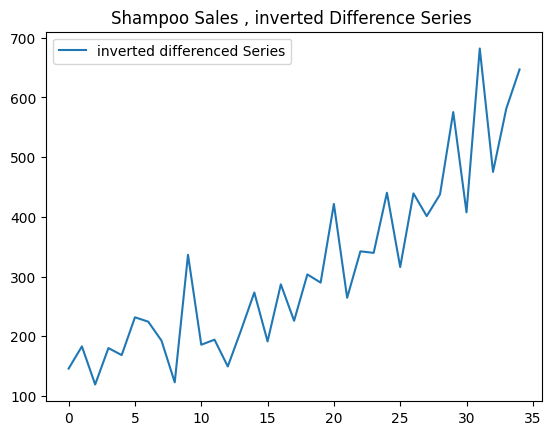

In [13]:
# check 
inverted = inverse_difference(series,diff_series)


# plot orginal vs difference
import matplotlib.pyplot as pyplot


pyplot.plot(inverted, label='inverted differenced Series')
#pyplot.plot(diff_series, label='differenced Series')

 

# Adding title
pyplot.title('Shampoo Sales , inverted Difference Series ')  

# Adding legend
pyplot.legend()

# Display the plot
pyplot.show()


### Transform Time Series to Scale

- Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.

- The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

- To make the experiment fair, the scaling coefficients (min and max) values must be calculated on the training dataset and applied to scale the test dataset and any forecasts. This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

- We can transform the dataset to the range [-1, 1] using the MinMaxScaler class. Like other scikit-learn transform classes, it requires data provided in a matrix format with rows and columns. Therefore, we must reshape our NumPy arrays before transforming.


#### Note on reshape(-1, 1):


- The reshape() method in NumPy changes the shape of the array without changing its data. The method allows you to specify the number of rows and columns you want the array to have.
- (-1, 1) is a specific argument used here:
- The -1 in the reshape method means "infer this dimension from the length of the array." In other words, NumPy will automatically calculate how many rows are needed based on the total number of elements in the array.
1 indicates that the reshaped array should have 1 column.
- As a result, reshape(-1, 1) converts a 1-dimensional array (shape: (n,)) into a 2-dimensional array with n rows and 1 column (shape: (n, 1)).

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def scale_series(series: pd.Series, feature_range: tuple = (-1, 1)) -> np.ndarray:
    """
    Scales the values of a pandas Series using MinMaxScaler.
    
    Parameters:
    series (pd.Series): The input pandas Series to be scaled.
    feature_range (tuple): The desired range of the transformed data. Default is (-1, 1).
    
    Returns:
    np.ndarray: A NumPy array containing the scaled values.
    """
    # Convert the series to a NumPy array and reshape it for scaling
    X = series.values.reshape(-1, 1)
    
    # Initialize the MinMaxScaler with the desired feature range
    scaler = MinMaxScaler(feature_range=feature_range)
    
    # Fit the scaler to the data and transform it
    scaled_X = scaler.fit_transform(X)
    
    return scaled_X


### Plot and check 

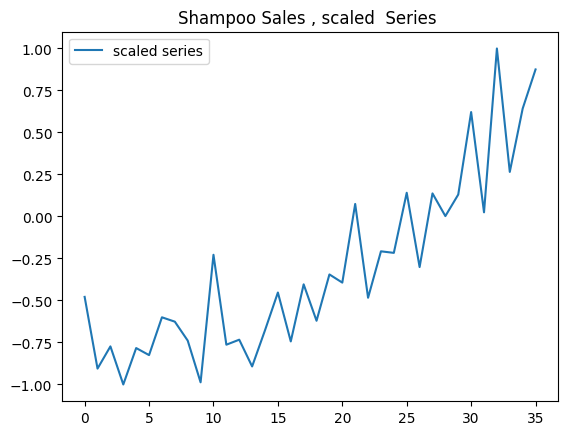

In [15]:
# check 
scaled_X  = scale_series(series)

# plot orginal vs difference
import matplotlib.pyplot as pyplot


pyplot.plot(scaled_X, label='scaled series')
#pyplot.plot(diff_series, label='differenced Series')

 

# Adding title
pyplot.title('Shampoo Sales , scaled  Series ')  

# Adding legend
pyplot.legend()

# Display the plot
pyplot.show()

####  Invert Scaling 

Again, we must invert the scale on forecasts to return the values back to the original scale so that the results can be interpreted and a comparable error score can be calculated.

The function invert_scaled_series does that as defined below 

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def invert_scaled_series(series: pd.Series, scaled_values: np.ndarray, feature_range: tuple = (-1, 1)) -> np.ndarray:
    """
    Inverts the scaling transformation on a pandas Series to recover the original values.
    
    Parameters:
    series (pd.Series): The original pandas Series before scaling.
    scaled_values (np.ndarray): The scaled NumPy array that needs to be inverted.
    feature_range (tuple): The range that was used for scaling. Default is (-1, 1).
    
    Returns:
    np.ndarray: A NumPy array containing the inverted values, which should closely approximate the original series values.
    """
    # Convert the series to a NumPy array and reshape it for scaling
    X = series.values.reshape(-1, 1)
    
    # Initialize the MinMaxScaler with the same feature range used during scaling
    scaler = MinMaxScaler(feature_range=feature_range)
    
    # Fit the scaler to the original data
    scaler = scaler.fit(X)
    
    # Invert the scaling transformation
    inverted_X = scaler.inverse_transform(scaled_values)
    
    return inverted_X


### Plot and check 

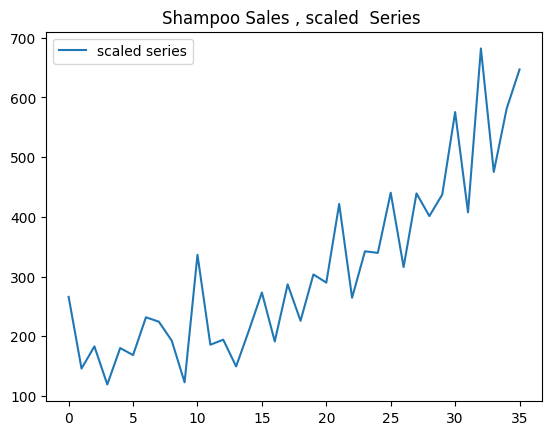

In [17]:
# invert scale
inverted_X = invert_scaled_series(series,scaled_X)

# check 

# plot orginal vs difference
import matplotlib.pyplot as pyplot


pyplot.plot(inverted_X, label='scaled series')
#pyplot.plot(diff_series, label='differenced Series')

 

# Adding title
pyplot.title('Shampoo Sales , scaled  Series ')  

# Adding legend
pyplot.legend()

# Display the plot
pyplot.show()

## LSTM Model  Development 


### KEY STEPS 

- Load data set 
- Plot data 
- Difference series for stationarity amd check 
- Transform Data to be supervised learning 
- Define LSTM Architecture 



## STEP 1 : Load Data 

In [18]:
# Define Time Series Data parser
def parser(x):
    return datetime.strptime('19' + x, '%Y-%b')

# Read Series
df = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)



# Convert to Series if it has a single column
if df.shape[1] == 1:
    series = df.squeeze(axis=1)
else:
    series = df

# Check
print(series.head())
raw_values = series.values

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


/var/folders/1m/07kgjdg97477jnhwzd0w8gyh0000gn/T/ipykernel_20871/1942467433.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)


## STEP 2 Plot Series 



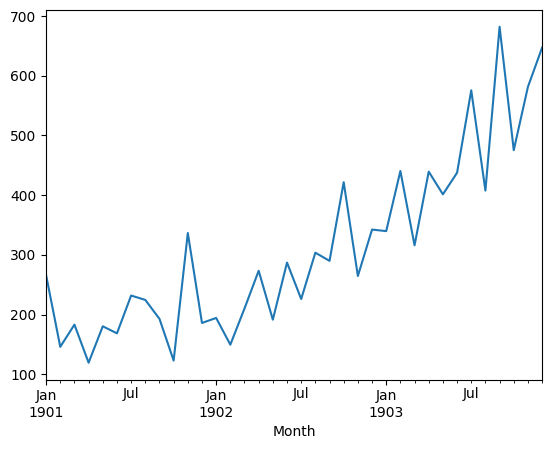

In [19]:
series.plot()
pyplot.show()

## STEP 3 : Difference Series for Stationarity and check 

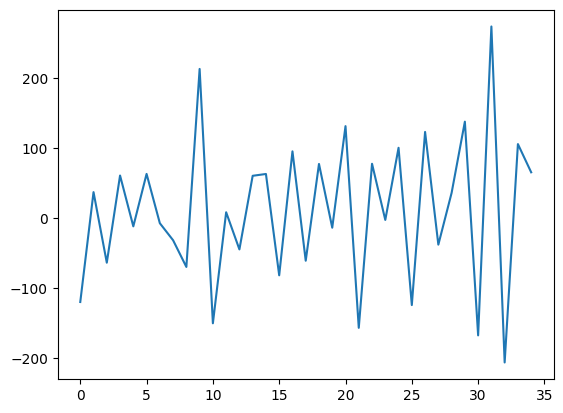

In [20]:
# difference the series
diff_values = difference_series(series, 1)

# plot and check 
diff_values.plot()
pyplot.show()

### STEP 4 : Transform Data for Supervised Learning

In [21]:
#  transform  columns 
supervised_df = add_shifted_column(diff_values )

# check
supervised_df.head()

,Original,Shifted
0,-120.1,0.0
1,37.2,-120.1
2,-63.8,37.2
3,61.0,-63.8
4,-11.8,61.0


In [22]:
# extract supervised learning values 
supervised_values = supervised_df.values 

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# check 
print(" --------     train data    ----------")
print("Train shape", train.shape)
print("                                      ")
print(train)
print(" --------     test data    ----------")

print("Test shape", test.shape)
print("                                      ")
print(test)
print("                                      ")



 --------     train data    ----------
Train shape (23, 2)
                                      
[[-120.1    0. ]
 [  37.2 -120.1]
 [ -63.8   37.2]
 [  61.   -63.8]
 [ -11.8   61. ]
 [  63.3  -11.8]
 [  -7.3   63.3]
 [ -31.7   -7.3]
 [ -69.9  -31.7]
 [ 213.6  -69.9]
 [-150.6  213.6]
 [   8.4 -150.6]
 [ -44.8    8.4]
 [  60.6  -44.8]
 [  63.2   60.6]
 [ -81.9   63.2]
 [  95.6  -81.9]
 [ -61.    95.6]
 [  77.6  -61. ]
 [ -13.7   77.6]
 [ 131.7  -13.7]
 [-157.1  131.7]
 [  77.8 -157.1]]
 --------     test data    ----------
Test shape (12, 2)
                                      
[[  -2.6   77.8]
 [ 100.7   -2.6]
 [-124.5  100.7]
 [ 123.4 -124.5]
 [ -38.   123.4]
 [  36.1  -38. ]
 [ 138.1   36.1]
 [-167.9  138.1]
 [ 274.4 -167.9]
 [-206.7  274.4]
 [ 106.  -206.7]
 [  65.6  106. ]]
                                      


## STEP 5 : Transform the scale of the data 

**Notes** 

- We use the train data set only to fit the Min Max Scaler 
- We use a slight different version of the scaling function we defined earlier as shown below 


In [23]:
#### Train Test Scaler 

from typing import Tuple
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def scale_data(train: np.ndarray, test: np.ndarray) -> Tuple[MinMaxScaler, np.ndarray, np.ndarray]:
    """
    Scale the train and test datasets to the range [-1, 1].

    Parameters:
    - train: numpy array, training data to be scaled
    - test: numpy array, test data to be scaled

    Returns:
    - scaler: fitted MinMaxScaler object
    - train_scaled: numpy array, scaled training data
    - test_scaled: numpy array, scaled test data
    """
    # Initialize the MinMaxScaler with the desired feature range
    scaler = MinMaxScaler(feature_range=(-1, 1))
    
    # Fit the scaler on the training data
    scaler.fit(train)
    
    # Reshape and scale the training data
    train_scaled = scaler.transform(train.reshape(train.shape[0], train.shape[1]))
    
    # Reshape and scale the test data
    test_scaled = scaler.transform(test.reshape(test.shape[0], test.shape[1]))
    
    return scaler, train_scaled, test_scaled


In [24]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale_data(train, test)

# check 
print(" --------     train data    ----------")
print("Train shape", train_scaled.shape)
print("                                      ")
print(train_scaled)
print(" --------     test data    ----------")

print("Test shape", test_scaled.shape)
print("                                      ")
print(test_scaled)
print("                                      ")


 --------     train data    ----------
Train shape (23, 2)
                                      
[[-0.80037766 -0.15241435]
 [ 0.04828702 -0.80037766]
 [-0.496628    0.04828702]
 [ 0.17669274 -0.496628  ]
 [-0.21607769  0.17669274]
 [ 0.1891017  -0.21607769]
 [-0.1917993   0.1891017 ]
 [-0.32344214 -0.1917993 ]
 [-0.52953871 -0.32344214]
 [ 1.         -0.52953871]
 [-0.96493121  1.        ]
 [-0.10709469 -0.96493121]
 [-0.39411923 -0.10709469]
 [ 0.17453466 -0.39411923]
 [ 0.18856218  0.17453466]
 [-0.59428109  0.18856218]
 [ 0.3633666  -0.59428109]
 [-0.48152145  0.3633666 ]
 [ 0.26625303 -0.48152145]
 [-0.22632857  0.26625303]
 [ 0.55813326 -0.22632857]
 [-1.          0.55813326]
 [ 0.26733207 -1.        ]]
 --------     test data    ----------
Test shape (12, 2)
                                      
[[-0.16644187  0.26733207]
 [ 0.39088211 -0.16644187]
 [-0.82411654  0.39088211]
 [ 0.51335312 -0.82411654]
 [-0.35743189  0.51335312]
 [ 0.04235231 -0.35743189]
 [ 0.59266253  0.04235

### LSTM Concept Note 


The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

#### The below Schematic shows an LSTM Cell 

Each module within LSTM consists of cells containing 4 gates. We will talk about each gate and what it’s purpose is.

REF: 
https://sullah.medium.com/understanding-lstms-from-scratch-pytorch-7020211fed40


Following are the gates and their purpose:

- f(t) : Forget Gate — Determines what information to forget/erase (usually unnecessary info)
- i(t) : Input Gate — What new information to add/write to the present cell.
- o(t) : Output Gate — what and how much to output from our cell state
- g(t) : Gate gate — how much new information to be added to the cell state.


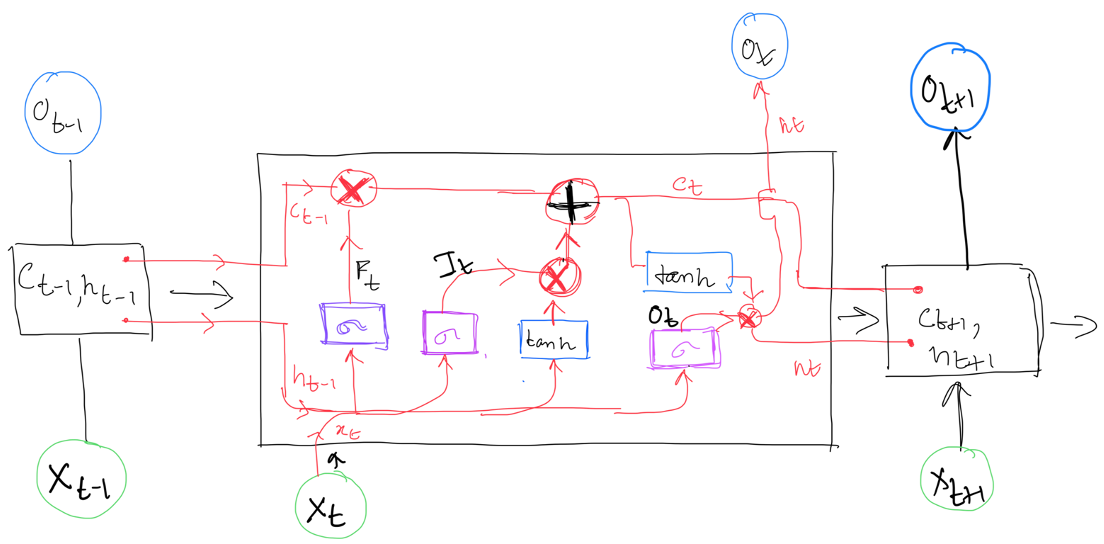

### The Forget Gate 

Because of the sequential nature of the model, each state gets information from the previous state. Once the output from the previous state h(t-1) is calculated, it is passed to the next. The function of Forget gate is to make a decision of what information needs to be kept from h(t-1) and what information must be removed, hence it only keeps the relevant information. The sigmoid function helps in constraining the input values between [0, 1]. 

#### The below schematic shows the representation of the forget gate 

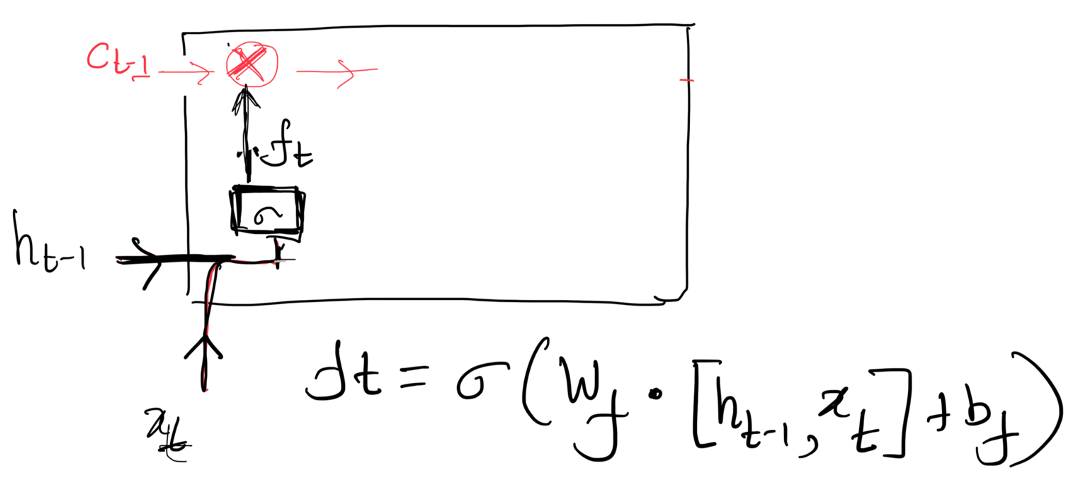

###  The Input Gate 

The input gate helps us determine what and how much new information should be added to the present cell state. x(t) is the current word representation.

#### The below schematic shows the representation of the input gate 

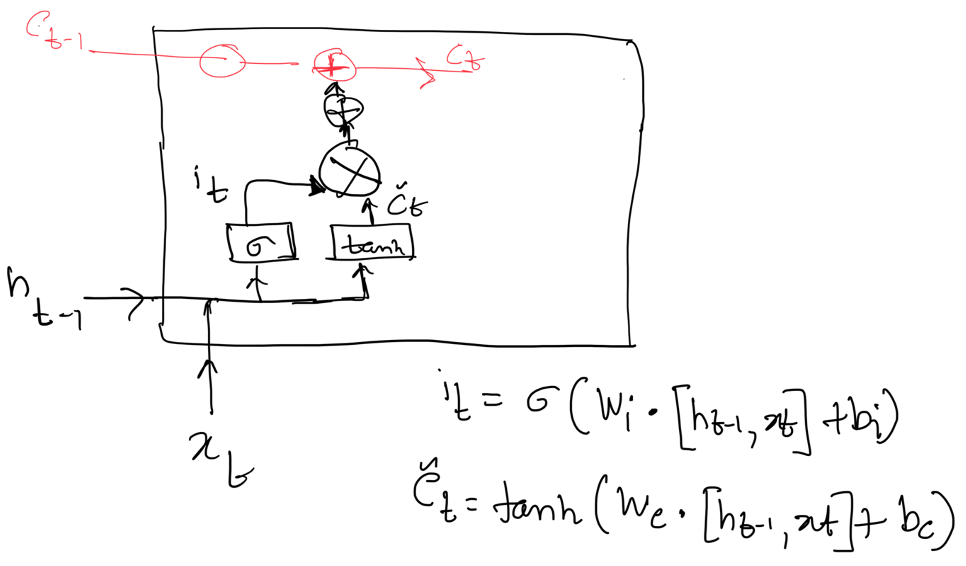

### Gate gate + Input Gate:

With reference to the picture above, the sigmoid layer is used to decide what values from the h(t-1) and x(t) are to be updated and a new vector is created based on the tanh layer. This operation decides what to add in the present state.

### Output Gate:

The last step is the output gate, in order to compute the output value from the gate, we compute the tanh of input (Ct) to constrain the values between [1 and -1]. It is then multiplied with output (Ot) that is the output from the sigmoid function. The computed value h(t) is the output from the current module and will be used in the next module as h(t-1).

#### The below schematic shows the representation of the output gate 

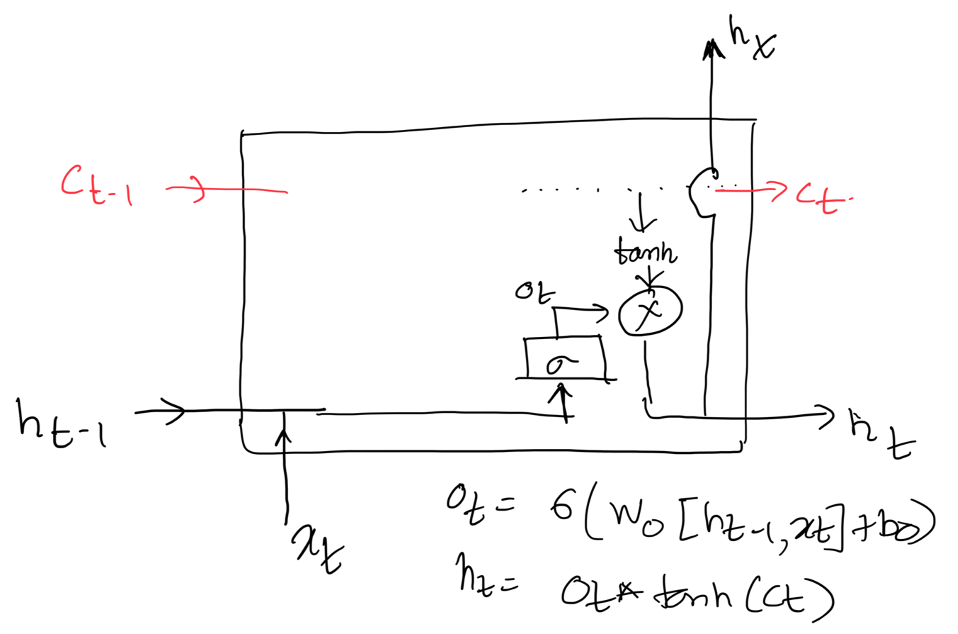

### STEP 6 LSTM Model Development 

We use Keras to develop the Model architecture. The function fit_lstm does the job as explained below :

**Notes on the function**


### Imports and annotations 

- **from keras.models import Sequential**: Sequential is used to build a linear stack of layers.
- **from keras.layers import LSTM, Dense**: LSTM and Dense are layer types used in the model.

### Function Signature:

The function fit_lstm takes four parameters:

- **train: np.ndarray:** The training data, where each row is a training example.
- **batch_size: int:** The batch size used during training.
- **nb_epoch: int:** The number of epochs to train the model.
- **neurons: int:** The number of neurons in the LSTM layer.
- The function returns a Sequential model.


### Data Preparation:

The training data train is split into:

- X: All columns except the last, which serve as input features.
- y: The last column, which serves as the target/output.
- X is reshaped to a 3D array, where the shape is [samples, timesteps, features]—a requirement for LSTM layers in Keras.

### Model Construction:

- A Sequential model is initialized.

- An LSTM layer is added with the specified number of neurons, using batch_input_shape to define the shape of input batches. 

- The model is stateful, meaning it maintains the state across batches.

- A Dense layer with 1 neuron is added as the output layer.


### Model Compilation:

- The model is compiled with the loss function mean_squared_error (suitable for regression tasks) and the adam optimizer, which is commonly used due to its adaptive learning rate.

### Training Loop:

- The model is trained for nb_epoch epochs. 
- During each epoch, the model fits the data in batches without shuffling (shuffle=False), which is important for stateful LSTM models.

- After each epoch, the model's states are reset using model.reset_states() to ensure that each epoch starts with a fresh state.




#### Function fit_lstm

In [25]:
from typing import Tuple
import tensorflow
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

def fit_lstm(
    train: np.ndarray, 
    batch_size: int, 
    nb_epoch: int, 
    neurons: int
) -> Sequential:
    """
    Fits an LSTM network to the training data.

    Args:
        train (np.ndarray): The training data, where each row is a training example.
        batch_size (int): The batch size for training.
        nb_epoch (int): The number of epochs to train the model.
        neurons (int): The number of neurons in the LSTM layer.

    Returns:
        Sequential: The trained LSTM model.
    """
    
    # Split the training data into inputs (X) and outputs (y)
    X, y = train[:, 0:-1], train[:, -1]
    
    # Reshape X to be 3D [samples, timesteps, features] as required by LSTM
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # Initialize the Sequential model
    model = Sequential()
    
    # Add the LSTM layer with the specified number of neurons
    #model.add(LSTM(neurons, input_shape=(X.shape[1], X.shape[2]),stateful=True))
    batch_size = 1  # Set a static batch size
    #model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(LSTM(neurons, input_shape=(X.shape[1], X.shape[2])))

    
    # Add a Dense layer with 1 neuron for the output
    model.add(Dense(1))
    
    # Compile the model with Mean Squared Error loss and the Adam optimizer
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Train the model for the specified number of epochs
    #for i in range(nb_epoch):
    model.fit(X, y, epochs=nb_epoch, batch_size=1, verbose=0)
        #model.reset_states()  # Reset states after each epoch when stateful=True
    
    return model


### STEP 7 : Train model 

**NOTES**

We use 2 hidden layer neurons and train for 800 epochs - this is purely arbitrary 

#### Fit the model 

In [26]:
# set model paramaters 

batch_size = 1
neurons = 4
nb_epoch = 1000


# fit model 
lstm_model = fit_lstm(train_scaled, batch_size, nb_epoch, neurons)

/Users/anishroychowdhury/anaconda3/envs/LLM/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### STEP 8 define function for a 1 step forecast 

#### Function Signature:

- The function forecast_lstm is defined with type annotations. It takes a Sequential model, an integer batch_size, and a NumPy array X as input, and returns a float.


#### Reshape Input:

- The input X is reshaped to meet the requirements of an LSTM model in Keras. LSTM models expect input in the format [samples, timesteps, features].

- In this case, since we are predicting for a single sample and a single timestep, the input is reshaped to (1, 1, len(X)).


#### Model Prediction:

- The reshaped input is passed to the model.predict() method. 
- The batch_size parameter is specified to match the model's training configuration.

#### Return Value:


The function returns the predicted value. Since the output is an array, the prediction is accessed using yhat[0, 0] to return the scalar value.

In [27]:
from keras.models import Sequential
import numpy as np

def forecast_lstm(model: Sequential, batch_size: int, X: np.ndarray) -> float:
    """
    Forecasts a single value using the LSTM model.

    Args:
        model (Sequential): The trained LSTM model.
        batch_size (int): The batch size to be used for prediction.
        X (np.ndarray): The input features for the prediction, expected to be a 1D array.

    Returns:
        float: The predicted value.
    """
    # Reshape the input to be compatible with LSTM input requirements [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    
    # Predict the output using the model
    yhat = model.predict(X, batch_size=batch_size)
    
    # Return the predicted value (first element)
    return yhat[0, 0]


### STEP 9  Define Function for inverting the scaling  for a 1 step forecast

We define this function slightly different from the version defined above.

#### Combining Features and Forecast:

- The np.append() method is used to combine the original input features X with the forecasted value value into a single array.

#### Reshape for Scaling:

- The combined array is reshaped to 2D using reshape(1, -1) because the inverse_transform method of scalers expects a 2D input.

#### Inversion of Scaling:

- The inverse_transform method of the scaler is used to revert the scaling applied to the data during preprocessing.

In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def invert_scaled(scaler: MinMaxScaler, X: np.ndarray, value: float) -> float:
    """
    Inverts the scaling for a forecasted value using the given scaler.

    Args:
        scaler (MinMaxScaler): The scaler used for normalizing the data.
        X (np.ndarray): The input features before the forecast.
        value (float): The forecasted value to be inverted.

    Returns:
        float: The value after inversion of the scaling.
    """
    # Combine the input features and the forecasted value into a single array
    new_row = np.append(X, value)
    
    # Reshape the array to 2D since scalers expect a 2D input
    new_row = new_row.reshape(1, -1)
    
    # Invert the scaling
    inverted = scaler.inverse_transform(new_row)
    
    # Return the inverted forecasted value
    return inverted[0, -1]

### STEP 10 Define Function for inverting the differencing for a 1 step forecast 

This function takes the differenced value (yhat) and adds it back to the last value in the history list to recover the original scale value before differencing.

This is slightly differently coded 

In [29]:
from typing import List

def inverse_difference(history: List[float], yhat: float, interval: int = 1) -> float:
    """
    Reverts the differencing process to obtain the original scale value.

    Args:
        history (List[float]): The historical raw time series data.
        yhat (float): The predicted value that needs to be inverted.
        interval (int): The difference interval, typically 1 for first differencing.

    Returns:
        float: The original scale value after inverting the difference.
    """
    # Add the differenced value (yhat) to the last known value in the original series (history[-interval])
    return yhat + history[-interval]


### STEP 11 Walk forward validation of predictions using test data 

The keys steps  are as below 

- **Initialize predictions  list:**
This list will store all the predicted values  generated during the walk-forward validation process. 


- **Walk-Forward Validation Loop:**
This loop iterates over each time step in the test_scaled dataset. The walk-forward validation evaluates the model on one time step at a time and updates the model with new data as it becomes available.


- **Extract Input and Expected Output:**
For each time step i, the input X (all features except the last one) and the expected output y (the last feature) are extracted from the test_scaled dataset.


- **One-Step Forecast:**
The forecast_lstm function is used to make a one-step forecast using the trained LSTM model. The input X is reshaped to match the LSTM's expected input dimensions. The function returns the predicted value yhat


- **Invert Scaling:**
Since the data was scaled (normalized) before being fed into the model, the prediction must be transformed back to its original scale. The invert_scaled_series function handles this by reversing the scaling applied to the data.

- **Invert Differencing:**
If the data was differenced to make it stationary, the prediction needs to be transformed back to the original scale by adding back the differenced value. The inverse_difference function performs this operation using the raw_values of the time series.


- **Store Forecast :**
The final forecasted value yhat is appended to the predictions list for later analysis or comparison with actual values.


- **Comparison with Expected Value:**
The expected value for the current time step is obtained from the raw_values (original time series data).
The predicted and expected values are then printed for comparison.

In [34]:
# Walk-forward validation on the test data
predicted = []

for i in range(len(test_scaled)):
    # Extract input features (X) and the true value (y) from the scaled test data
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]

    # Make a one-step forecast using the LSTM model
    yhat = forecast_lstm(lstm_model, batch_size=1, X=X)

    # Invert the scaling to return the forecast to its original scale
    yhat = invert_scaled(scaler, X, yhat)

    # Invert the differencing to return the forecast to the original data scale
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)

    # Store the forecasted value
    predicted.append(yhat)

    # Retrieve the expected (true) value from the original raw values
    expected = raw_values[len(train) + i + 1]

    # Print the month, predicted value, and expected value
    print(f'Month={i+1}, Predicted={yhat:.6f}, Expected={expected:.6f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Month=1, Predicted=327.716627, Expected=339.700000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Month=2, Predicted=278.388563, Expected=440.400000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Month=3, Predicted=544.140828, Expected=315.900000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Month=4, Predicted=251.609931, Expected=439.300000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Month=5, Predicted=453.894467, Expected=401.300000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Month=6, Predicted=362.345924, Expected=437.400000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Month=7, Predicted=372.308568, Expected=575.500000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Month=8, Predicted=725.895944, Expected=407.600000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Month=9, Predicted=360.794690, Expected=682.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Month=10, Predicted=871.273151, Expected=475.300000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Month=11, Predicted=413.090449, Expected=581.300000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7

### Step 12  Plot and compare

Test RMSE: 217.329


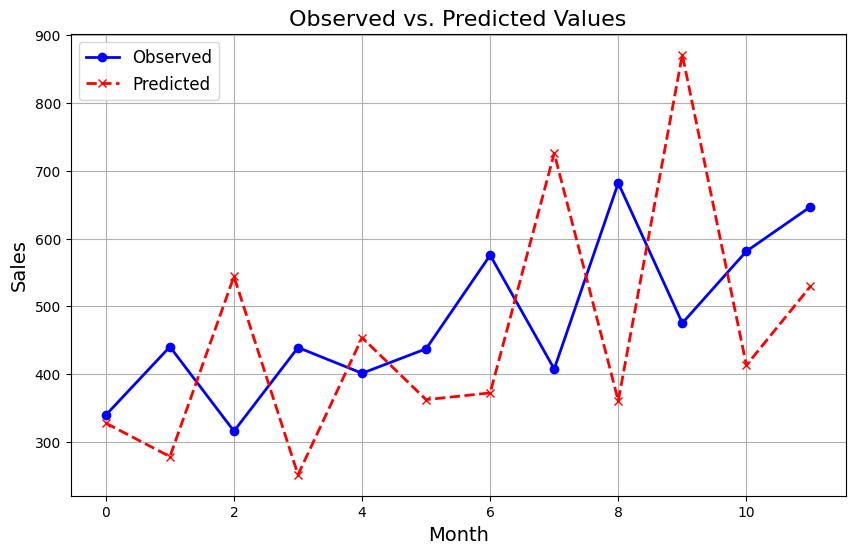

In [39]:
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pyplot

# Calculate RMSE (Root Mean Squared Error) between the actual and predicted values
rmse = sqrt(mean_squared_error(raw_values[-12:], predicted))
print(f'Test RMSE: {rmse:.3f}')

# Plot observed vs. predicted values
pyplot.figure(figsize=(10, 6))  # Set the figure size for better visibility

# Plot the actual observed values
pyplot.plot(raw_values[-12:], label='Observed', marker='o', color='blue', linestyle='-', linewidth=2)

# Plot the predicted values
pyplot.plot(predicted, label='Predicted', marker='x', color='red', linestyle='--', linewidth=2)

# Adding titles and labels
pyplot.title('Observed vs. Predicted Values', fontsize=16)
pyplot.xlabel('Month', fontsize=14)
pyplot.ylabel('Sales', fontsize=14)

# Adding a legend to the plot
pyplot.legend(loc='upper left', fontsize=12)

# Display the plot
pyplot.grid(True)  # Adding a grid for better readability
pyplot.show()


### End of notebook